In [6]:
import kagglehub
import pandas as pd 

### Dataset download 

In [8]:
# Download latest version
path = kagglehub.dataset_download("selimm/book-sales")
print(path)
data=pd.read_csv('C:/Users/user/Desktop/DataScience/Data/book_sales.csv')


100%|██████████| 1.66k/1.66k [00:00<00:00, 1.70MB/s]

Extracting files...
C:\Users\user\.cache\kagglehub\datasets\selimm\book-sales\versions\1


In [6]:
data=pd.read_csv('C:/Users/user/Desktop/DataScience/Data/book_sales.csv')
df=data.copy()
pjme =pd.read_csv('C:/Users/user/Desktop/DataScience/Data/book_sales.csv',
                  index_col=[0],
                  parse_dates=[0])
pjme.head()

,Value
Period,
1992-01-01,790
1992-02-01,539
1992-03-01,535
1992-04-01,523
1992-05-01,552


In [12]:
df.head(n=10)

,Period,Value
0,Jan-1992,790
1,Feb-1992,539
2,Mar-1992,535
3,Apr-1992,523
4,May-1992,552
5,Jun-1992,589
6,Jul-1992,592
7,Aug-1992,894
8,Sep-1992,861
9,Oct-1992,645


In [16]:
import numpy as np
df['Time'] = np.arange(len(df.index))
df

,Period,Value,Time
0,Jan-1992,790,0
1,Feb-1992,539,1
2,Mar-1992,535,2
3,Apr-1992,523,3
4,May-1992,552,4
...,...,...,...
343,Aug-2020,725,343
344,Sep-2020,583,344
345,Oct-2020,427,345
346,Nov-2020,465,346


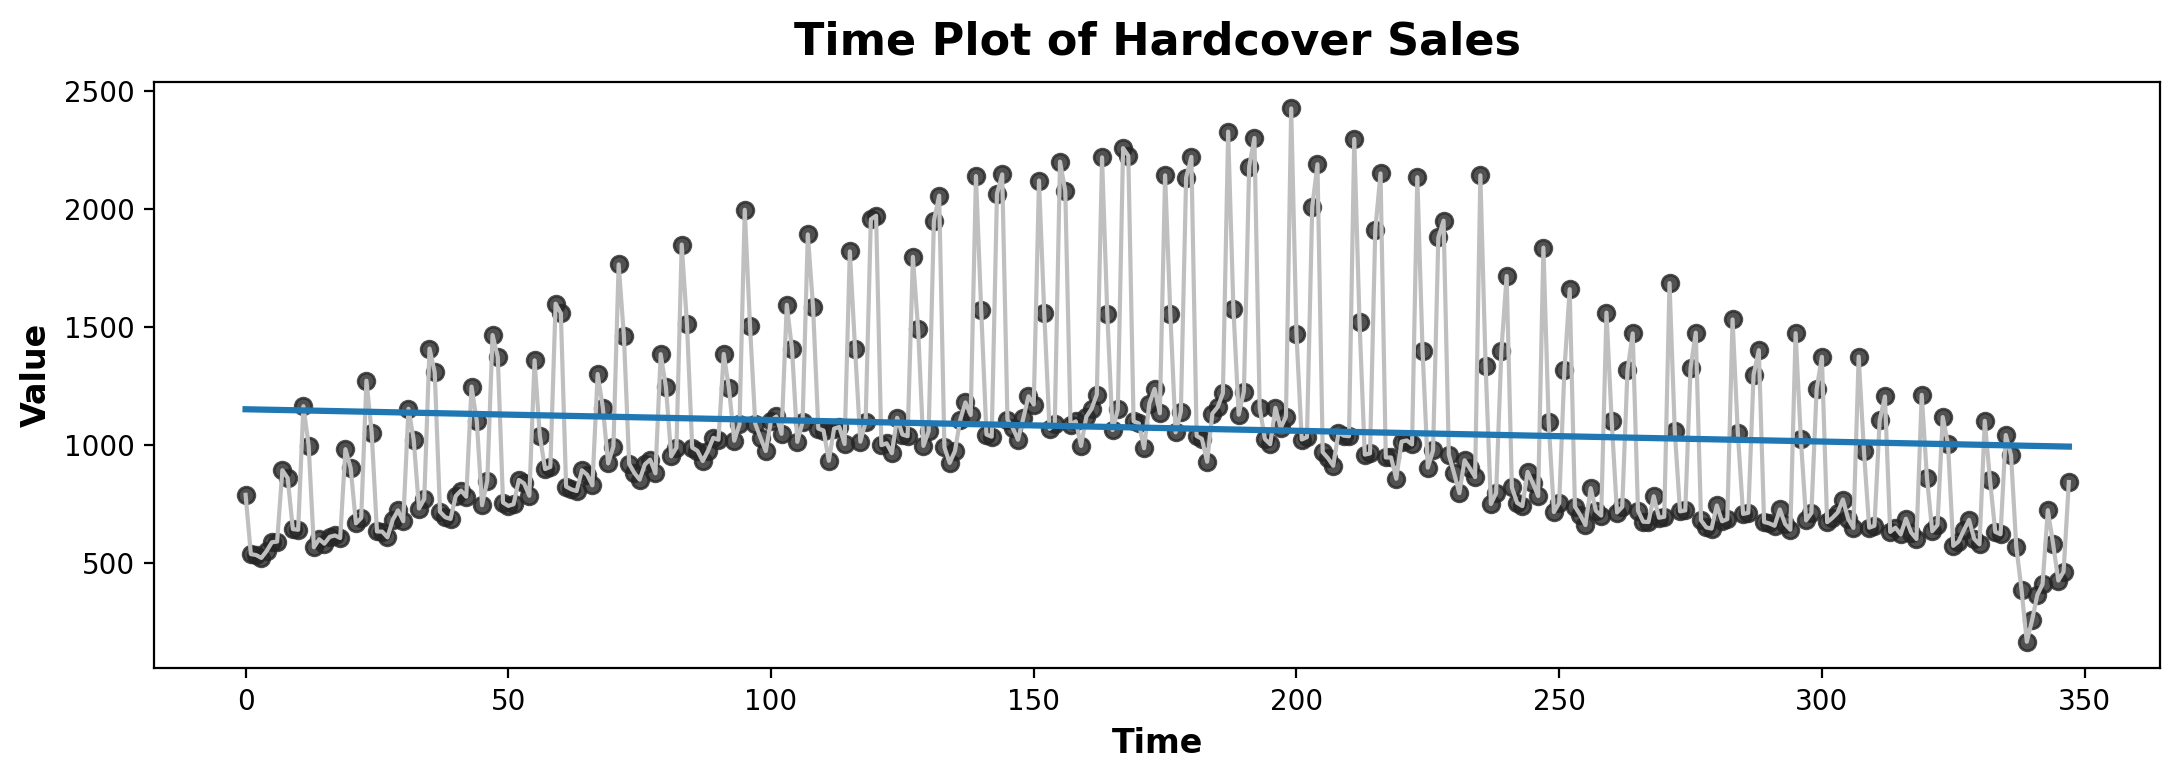

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns



# Customize figure and axes appearance
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold'
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

# Ensure that inline plotting uses high-quality rendering
%config InlineBackend.figure_format = 'retina'

# Create a plot with customized style and axes
fig, ax = plt.subplots()
ax.plot('Time', 'Value', data=df, color='0.75')  # Ensure 'Hardcover' matches the column name in df
ax = sns.regplot(x='Time', y='Value', data=df, ci=None, scatter_kws=dict(color='0.15'))

ax.set_title('Time Plot of Hardcover Sales')  # Set the title for the plot
plt.show()


In [30]:
df['Lag_1'] = df['Value'].shift(1)
df = df.reindex(columns=['Value', 'Lag_1'])

df.head()

,Value,Lag_1
0,790,NaN
1,539,790.0
2,535,539.0
3,523,535.0
4,552,523.0


### TIme Series 

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from prophet import Prophet

from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')




In [50]:
def mean_absolute_percentage_error(y_true,y_pred):
    """Calculate MAPE given y_true and y_pred"""
    y_true,y_pred=np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) *100

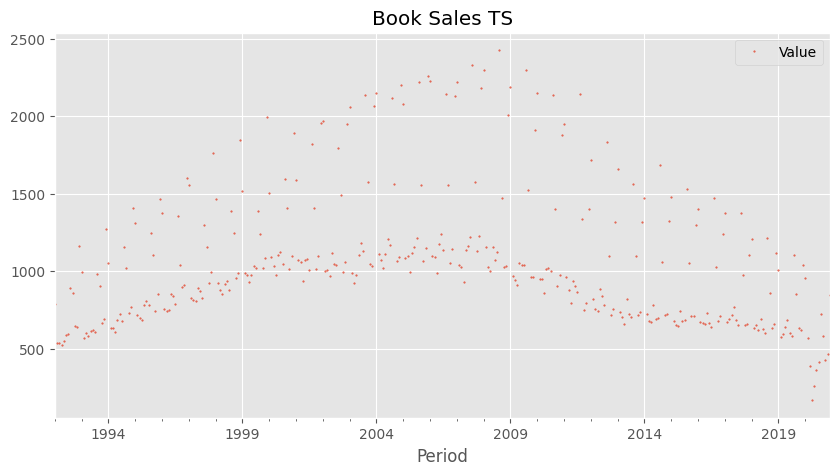

In [9]:
pjme.head()
color_pal =sns.color_palette()
pjme.plot(style='.',
          figsize=(10,5),
          ms=1,
          color=color_pal[0],
          title='Book Sales TS'
          )

plt.show()

In [13]:
from pandas.api.types import CategoricalDtype
import pandas as pd

cat_type = CategoricalDtype(categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
], ordered=True)

def create_features(df, label=None):
    """Creates time series features from datetime index"""
    
    # Ensure the index is datetime if it is not already
    df.index = pd.to_datetime(df.index, errors='coerce')  # Convert index to datetime, handle errors if any
    
    new_df = df.copy()
    
    # Add the 'date' column from the index
    new_df['date'] = df.index
    
    # Extract features from the 'date' column
    new_df['hour'] = new_df['date'].dt.hour
    new_df['dayofweek'] = new_df['date'].dt.dayofweek  # Fix typo here: dayofweek instead of dayofweeek
    new_df['weekday'] = new_df['date'].dt.day_name()
    new_df['weekday'] = new_df['weekday'].astype(cat_type)
    new_df['quarter'] = new_df['date'].dt.quarter
    new_df['month'] = new_df['date'].dt.month
    new_df['year'] = new_df['date'].dt.year
    new_df['dayofyear'] = new_df['date'].dt.dayofyear
    new_df['dayofmonth'] = new_df['date'].dt.day
    new_df['weekofyear'] = new_df['date'].dt.isocalendar().week  # Update to use isocalendar for weekofyear
    
    # Create 'date_offset' and 'season'
    new_df['date_offset'] = (new_df['date'].dt.month * 100 * new_df['date'].dt.day - 320) % 1300
    new_df['season'] = pd.cut(new_df['date_offset'], [0, 300, 602, 900, 1300],
                              labels=['Spring', 'Summer', 'Fall', 'Winter'])
    
    # Extract feature columns
    X = new_df[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'weekday', 'season']]
    
    # Return both features and target if label is specified
    if label:
        y = df[label]
        return X, y
    
    return X

# Usage
X, y = create_features(pjme, label='Value')
features_and_target = pd.concat([X, y], axis=1)


In [14]:
features_and_target.head(n=10)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,Value
Period,,,,,,,,,,,
1992-01-01,0,2,1,1,1992,1,1,1,Wednesday,Winter,790
1992-02-01,0,5,1,2,1992,32,1,5,Saturday,Winter,539
1992-03-01,0,6,1,3,1992,61,1,9,Sunday,Winter,535
1992-04-01,0,2,2,4,1992,92,1,14,Wednesday,Spring,523
1992-05-01,0,4,2,5,1992,122,1,18,Friday,Spring,552
1992-06-01,0,0,2,6,1992,153,1,23,Monday,Spring,589
1992-07-01,0,2,3,7,1992,183,1,27,Wednesday,Summer,592
1992-08-01,0,5,3,8,1992,214,1,31,Saturday,Summer,894
1992-09-01,0,1,3,9,1992,245,1,36,Tuesday,Summer,861


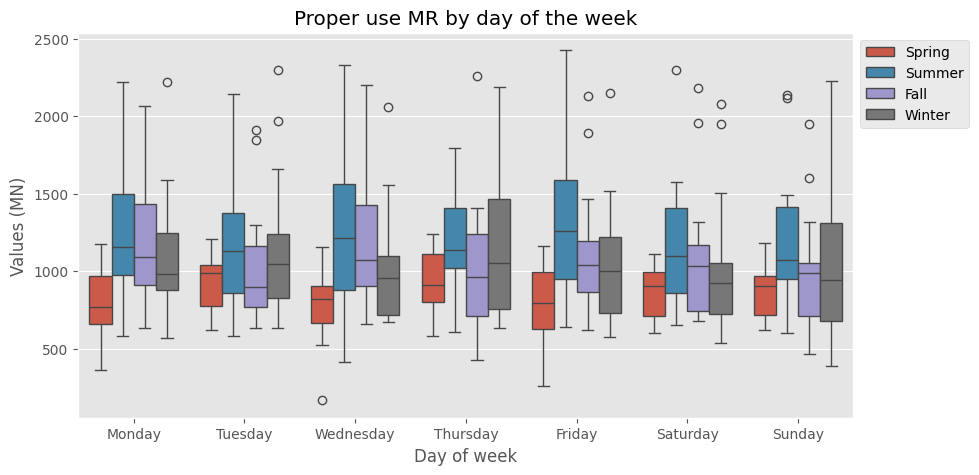

In [17]:
fig,ax=plt.subplots(figsize=(10,5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='Value',
            hue='season',
            ax=ax,
            linewidth=1)

ax.set_title('Proper use MR by day of the week')
ax.set_xlabel('Day of week')
ax.set_ylabel('Values (MN)')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

### Train /Test split

Index(['TRAINING SET'], dtype='object')


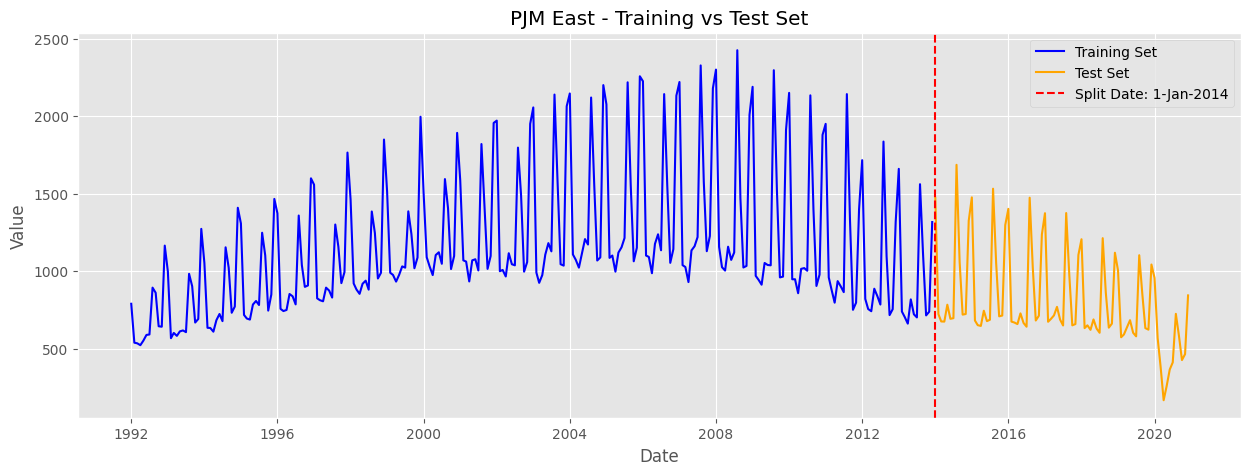

In [25]:
import matplotlib.pyplot as plt

# Set a more reasonable split date. For example, use a date like '1-Jan-2014' for splitting.
split_date = '1-Jan-2014'

# Create train and test datasets based on the split date
pjme_train = pjme.loc[pjme.index < split_date].copy()  # Data before split date
pjme_test = pjme.loc[pjme.index >= split_date].copy()  # Data after split date

# Rename the columns for both training and test sets
pjme_test_renamed = pjme_test.rename(columns={'Value': 'TEST SET'})
pjme_train_renamed = pjme_train.rename(columns={'Value': 'TRAINING SET'})

# Verify the column names after renaming
print(pjme_train_renamed.columns)  # Make sure 'TRAINING SET' is in the columns of the training data

# Plot both training and test sets on the same graph for visual comparison
plt.figure(figsize=(15, 5))

# Plot training set
plt.plot(pjme_train_renamed.index, pjme_train_renamed['TRAINING SET'], label='Training Set', color='blue')

# Plot test set
plt.plot(pjme_test_renamed.index, pjme_test_renamed['TEST SET'], label='Test Set', color='orange')

# Add a vertical line to show the split point clearly
plt.axvline(x=pd.to_datetime(split_date), color='red', linestyle='--', label=f'Split Date: {split_date}')

# Add labels, title, and legend
plt.title('PJM East - Training vs Test Set')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()



In [31]:
# Reset index to use the 'Datetime' column properly and rename 'PJME_MR' to 'Value'
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={
        'Period': 'ds',  # Rename 'Datetime' to 'ds' for Prophet
        'Value': 'y'  # Rename 'PJME_MR' to 'Value'
    })

# Display the first few rows to confirm the changes
print(pjme_train_prophet.head())


          ds    y
0 1992-01-01  790
1 1992-02-01  539
2 1992-03-01  535
3 1992-04-01  523
4 1992-05-01  552


03:04:15 - cmdstanpy - INFO - Chain [1] start processing
03:04:15 - cmdstanpy - INFO - Chain [1] done processing


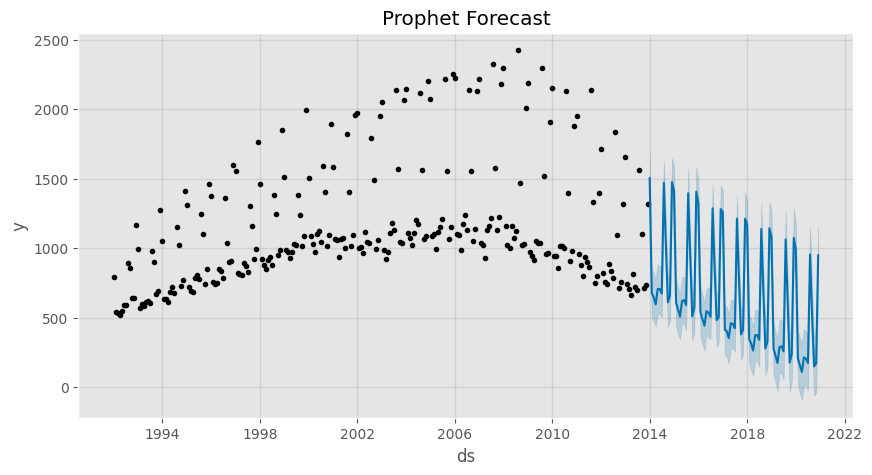

CPU times: total: 547 ms
Wall time: 1.22 s


In [38]:
%%time
model=Prophet()
print(model.fit(pjme_train_prophet))

pjme_test_prophet=pjme_test.reset_index() \
.rename(columns={'Period':'ds',
                 'Value':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

pjme_test_fcst.head()

fig,ax=plt.subplots(figsize=(10,5))
fig=model.plot(pjme_test_fcst,ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

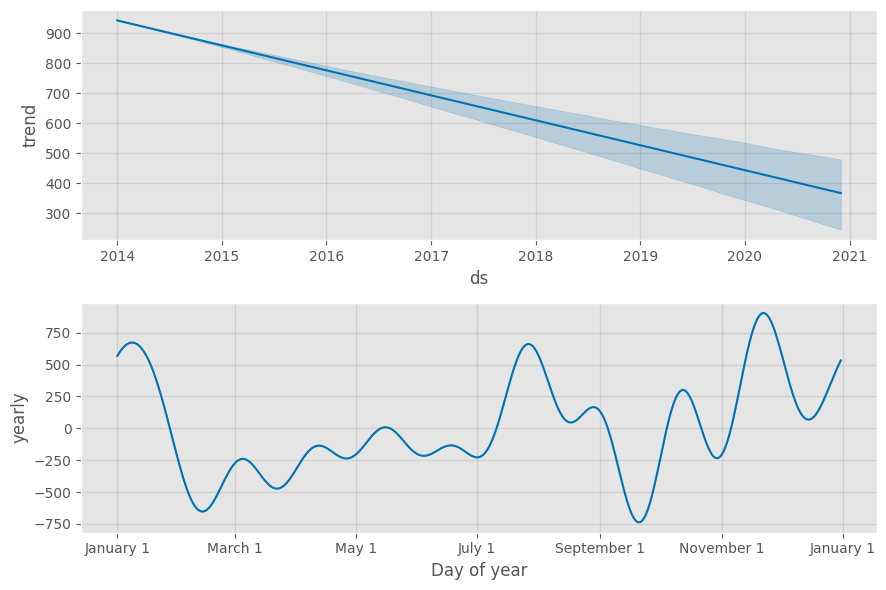

In [39]:
fig=model.plot_components(pjme_test_fcst
                          )
plt.show()

### Compare forecst to actual values

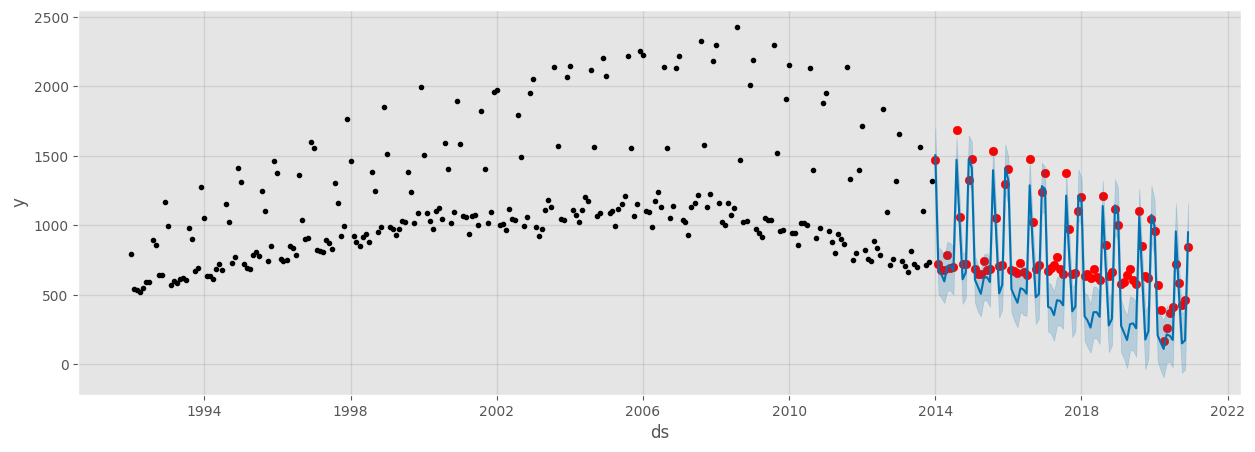

In [40]:
f,ax=plt.subplots(figsize=(15,5))
ax.scatter(pjme_test.index,pjme_test['Value'],color='r')
fig=model.plot(pjme_test_fcst,ax=ax)

In [44]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,942.310292,1333.978872,1697.444103,942.310292,942.310292,561.984853,561.984853,561.984853,561.984853,561.984853,561.984853,0.0,0.0,0.0,1504.295145
1,2014-02-01,935.260312,505.916308,844.466981,935.222057,935.260312,-257.873198,-257.873198,-257.873198,-257.873198,-257.873198,-257.873198,0.0,0.0,0.0,677.387114
2,2014-03-01,928.892589,478.736571,823.632367,928.665158,929.023214,-280.129103,-280.129103,-280.129103,-280.129103,-280.129103,-280.129103,0.0,0.0,0.0,648.763486
3,2014-04-01,921.842609,440.891806,775.878101,921.341580,922.194216,-325.727477,-325.727477,-325.727477,-325.727477,-325.727477,-325.727477,0.0,0.0,0.0,596.115132
4,2014-05-01,915.020048,529.375274,882.106846,914.201656,915.698701,-208.033086,-208.033086,-208.033086,-208.033086,-208.033086,-208.033086,0.0,0.0,0.0,706.986961


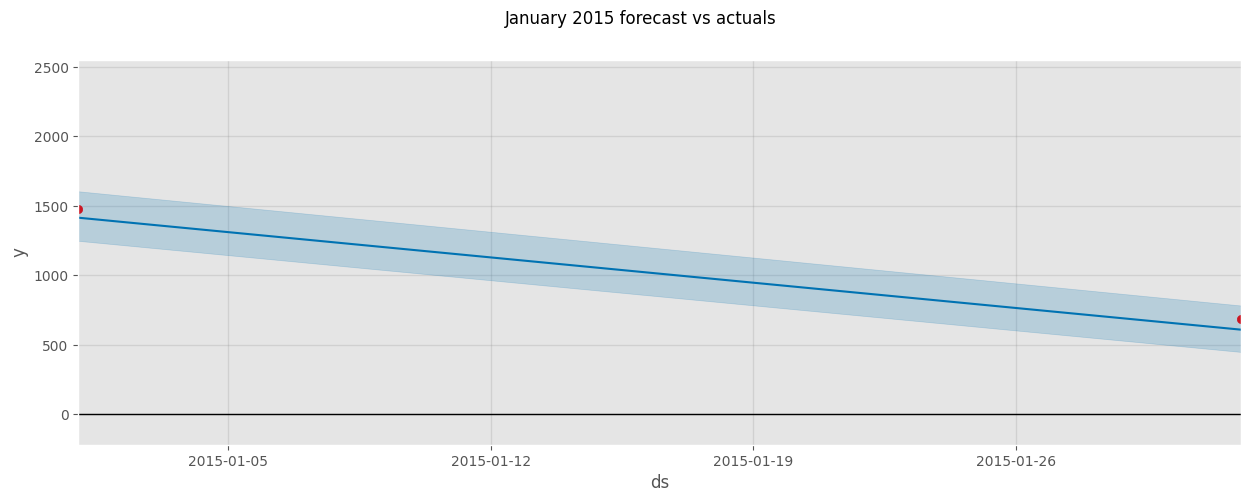

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the 'pjme_test.index' is of type datetime
# Convert the 'lower' and 'upper' bounds to datetime objects
lower_date = pd.to_datetime('01-01-2015')
upper_date = pd.to_datetime('02-01-2015')

# Create the plot
f, ax = plt.subplots(figsize=(15, 5))

# Plot actual data
ax.scatter(pjme_test.index, pjme_test['Value'], color='r')

# Plot forecasted data (assuming 'pjme_test_fcst' is a DataFrame)
fig = model.plot(pjme_test_fcst, ax=ax)

# Set the x-axis limits to the desired range
ax.set_xbound(lower=lower_date, upper=upper_date)

# Set y-axis line at 0
ax.axhline(0, color='black', linewidth=1)

# Add title
plot = plt.suptitle('January 2015 forecast vs actuals')

# Show the plot
plt.show()


In [48]:
mean_absolute_error(y_true=pjme_test['Value'],
                    y_pred=pjme_test_fcst['yhat'])

180.12903302249472

In [51]:
mean_absolute_percentage_error(y_true=pjme_test['Value'],
                               y_pred=pjme_test_fcst['yhat'])

np.float64(27.09681781153444)

### Adding Holidays 

In [52]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar 


In [58]:
cal=calendar()

holidays=cal.holidays(start=pjme.index.min(),
                      end=pjme.index.max(),
                      return_name=True)

holiday_df = pd.DataFrame(
    data=holidays,
    columns=['holiday_name']
) \
.assign(holiday ='USFederalHoliday')
holidays

1992-01-01                         New Year's Day
1992-01-20    Birthday of Martin Luther King, Jr.
1992-02-17                  Washington's Birthday
1992-05-25                           Memorial Day
1992-07-03                       Independence Day
                             ...                 
2020-07-03                       Independence Day
2020-09-07                              Labor Day
2020-10-12                           Columbus Day
2020-11-11                           Veterans Day
2020-11-26                       Thanksgiving Day
Length: 289, dtype: object

In [59]:
holiday_df['holiday_name'].value_counts()

holiday_name
New Year's Day                         29
Birthday of Martin Luther King, Jr.    29
Washington's Birthday                  29
Memorial Day                           29
Independence Day                       29
Labor Day                              29
Columbus Day                           29
Veterans Day                           29
Thanksgiving Day                       29
Christmas Day                          28
Name: count, dtype: int64

In [60]:
holiday_df.head()

,holiday_name,holiday
1992-01-01,New Year's Day,USFederalHoliday
1992-01-20,"Birthday of Martin Luther King, Jr.",USFederalHoliday
1992-02-17,Washington's Birthday,USFederalHoliday
1992-05-25,Memorial Day,USFederalHoliday
1992-07-03,Independence Day,USFederalHoliday


In [68]:

holiday_d_frame=holiday_df.reset_index().rename(columns={'index':'ds'})
holiday_d_frame.head()



,ds,ds,ds,ds,ds,ds,ds,holiday_name,holiday
0,0,0,0,0,0,0,1992-01-01,New Year's Day,USFederalHoliday
1,1,1,1,1,1,1,1992-01-20,"Birthday of Martin Luther King, Jr.",USFederalHoliday
2,2,2,2,2,2,2,1992-02-17,Washington's Birthday,USFederalHoliday
3,3,3,3,3,3,3,1992-05-25,Memorial Day,USFederalHoliday
4,4,4,4,4,4,4,1992-07-03,Independence Day,USFederalHoliday


In [70]:
# Python
facebook_df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
facebook_df.head()
new_facebook_df =facebook_df.copy()
new_facebook_df.tail()


,ds,y
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871
2904,2016-01-20,8.891374


In [90]:
m=Prophet()
m.fit(new_facebook_df)

08:51:54 - cmdstanpy - INFO - Chain [1] start processing
08:51:56 - cmdstanpy - INFO - Chain [1] done processing


In [73]:
future=m.make_future_dataframe(periods=365)
future.head()

,ds
0,2007-12-10
1,2007-12-11
2,2007-12-12
3,2007-12-13
4,2007-12-14


In [74]:
forecast=m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_lower']].tail()



,ds,yhat,yhat_lower,yhat_lower
3265,2017-01-15,8.206964,7.487474,7.487474
3266,2017-01-16,8.531958,7.790216,7.790216
3267,2017-01-17,8.319376,7.582260,7.582260
3268,2017-01-18,8.151991,7.432932,7.432932
3269,2017-01-19,8.163908,7.402936,7.402936


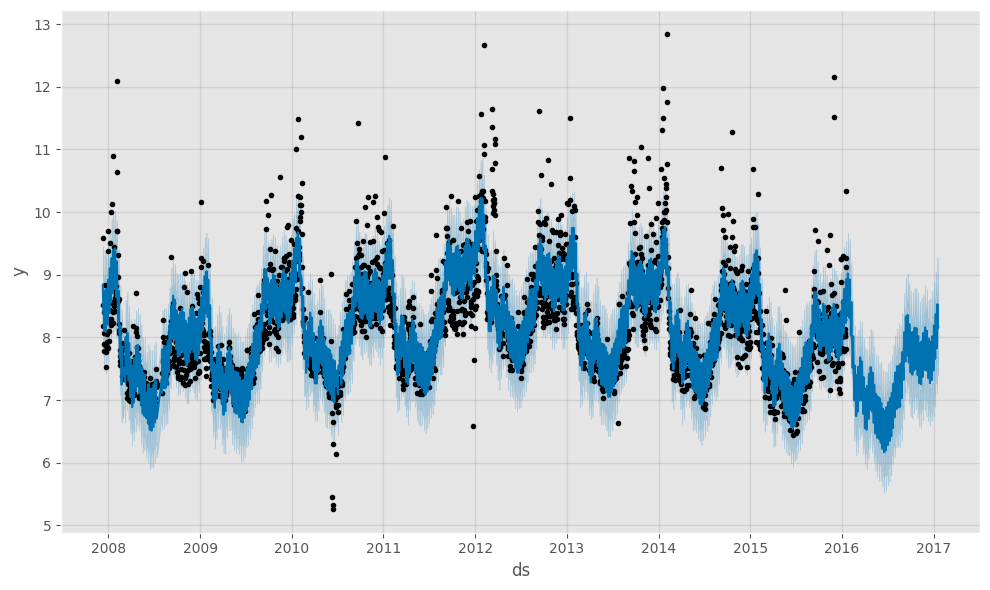

In [75]:
fig1=m.plot(forecast)

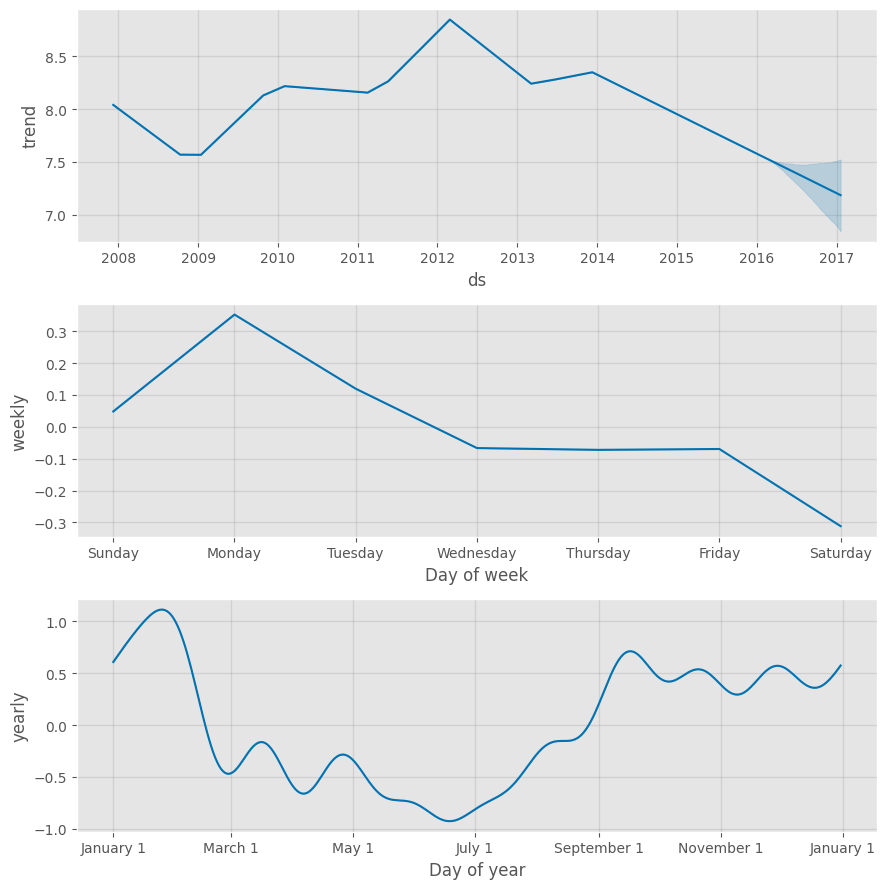

In [76]:
fig2=m.plot_components(forecast)

In [87]:
import plotly.express as px

# Combine the history and forecast data for plotting
combined_df = m.history[['ds', 'y']].merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

# Create the plot
fig = px.line(combined_df, x='ds', y='yhat', title='Prophet Forecast')
fig.add_scatter(x=combined_df['ds'], y=combined_df['y'], mode='markers', name='Actual')

# Add uncertainty interval
fig.add_scatter(x=combined_df['ds'], y=combined_df['yhat_upper'], mode='lines', line=dict(width=0), name='Upper Bound')
fig.add_scatter(x=combined_df['ds'], y=combined_df['yhat_lower'], mode='lines', line=dict(width=0), 
                fillcolor='rgba(0, 0, 255, 0.2)', fill='tonexty', name='Lower Bound')

# Show the plot
fig.show()

In [88]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a subplot for each component
fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=("Trend", "Weekly Seasonality", "Yearly Seasonality", "Holiday Effects")
)

# Add Trend
fig.add_trace(
    go.Scatter(x=forecast['ds'], y=forecast['trend'], mode='lines', name='Trend'),
    row=1, col=1
)

# Add Weekly Seasonality
fig.add_trace(
    go.Scatter(x=forecast['ds'], y=forecast['weekly'], mode='lines', name='Weekly Seasonality'),
    row=2, col=1
)

# Add Yearly Seasonality
fig.add_trace(
    go.Scatter(x=forecast['ds'], y=forecast['yearly'], mode='lines', name='Yearly Seasonality'),
    row=3, col=1
)

# Add Holiday Effects (if applicable)
if 'holidays' in forecast.columns:
    fig.add_trace(
        go.Scatter(x=forecast['ds'], y=forecast['holidays'], mode='lines', name='Holiday Effects'),
        row=4, col=1
    )

# Update layout
fig.update_layout(
    title_text="Forecast Components",
    height=800,
    showlegend=False
)

# Update y-axis titles
fig.update_yaxes(title_text="Trend", row=1, col=1)
fig.update_yaxes(title_text="Weekly", row=2, col=1)
fig.update_yaxes(title_text="Yearly", row=3, col=1)
if 'holidays' in forecast.columns:
    fig.update_yaxes(title_text="Holidays", row=4, col=1)

# Show the plot
fig.show()

In [78]:
help(Prophet)

Help on class Prophet in module prophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None, scaling: str = 'absmax', holidays_mode=None)
 |
 |  Prophet forecaster.
 |
 |  Parameters
 |  ----------
 |  growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or
 |      flat trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_chan

In [92]:
print(m.changepoints)

93     2008-03-17
186    2008-06-20
279    2008-10-11
372    2009-01-14
465    2009-04-17
558    2009-07-19
650    2009-10-26
743    2010-01-31
836    2010-05-06
929    2010-08-14
1022   2010-11-15
1115   2011-02-16
1208   2011-05-20
1301   2011-08-21
1394   2011-11-24
1487   2012-02-27
1580   2012-05-31
1673   2012-09-01
1765   2012-12-02
1858   2013-03-05
1951   2013-06-06
2044   2013-09-08
2137   2013-12-10
2230   2014-03-14
2323   2014-06-15
Name: ds, dtype: datetime64[ns]


In [93]:
# Magnitude of changepoints
trend_changes = forecast['trend'].diff().abs()
print("Trend Changes:", trend_changes[trend_changes > 0])

Trend Changes: 1       0.001540
2       0.001540
3       0.001540
4       0.001540
5       0.001540
          ...   
3265    0.001025
3266    0.001025
3267    0.001025
3268    0.001025
3269    0.001025
Name: trend, Length: 3269, dtype: float64


In [94]:
# Access seasonality parameters
print("Seasonality Parameters:", m.seasonalities)

Seasonality Parameters: OrderedDict({'yearly': {'period': 365.25, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None}, 'weekly': {'period': 7, 'fourier_order': 3, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None}})


In [95]:
# Access holidays
print("Holidays:", m.holidays)

Holidays: None


In [97]:
# Print the forecast dataframe
print(forecast[['ds', 'trend', 'weekly', 'yearly']].head())

          ds     trend    weekly    yearly
0 2007-12-10  8.039995  0.352285  0.450787
1 2007-12-11  8.038455  0.119640  0.433524
2 2007-12-12  8.036915 -0.066661  0.417196
3 2007-12-13  8.035375 -0.072268  0.402248
4 2007-12-14  8.033835 -0.069578  0.389085


In [98]:
# Print uncertainty intervals
print(forecast[['ds', 'yhat_lower', 'yhat_upper']].head())

          ds  yhat_lower  yhat_upper
0 2007-12-10    8.200062    9.461489
1 2007-12-11    7.959321    9.215591
2 2007-12-12    7.776611    8.929861
3 2007-12-13    7.713162    8.982938
4 2007-12-14    7.718882    8.983017


In [101]:
new_facebook_df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [102]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate metrics
mae = mean_absolute_error(new_facebook_df['y'], forecast['yhat'][:len(new_facebook_df)])
mse = mean_squared_error(new_facebook_df['y'], forecast['yhat'][:len(new_facebook_df)])
rmse = mse ** 0.5

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

MAE: 0.3356569476752214
MSE: 0.23392740293667083
RMSE: 0.48366042109797536
